In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

import warnings

# ML Libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Models
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# KNN
from sklearn.neighbors import KNeighborsClassifier

#pip install miceforest
from miceforest import ImputationKernel

import sqlite3

warnings.filterwarnings('ignore')

In [2]:
con = sqlite3.connect('database.db')
raw = pd.read_sql_query('SELECT*FROM players', con)
original = raw.copy()
len(raw)

5222

In [3]:
raw.head()

,player_id,player_name,year,School,position_combine,height,ht,weight,forty_yard,vertical_leap,...,position_nfl,position_nfl_std,bench_press_score,broad_jump_score,forty_yard_score,shuttle_run_score,three_cone_score,vertical_leap_score,combine_score,draft_pick_flag
0,2000ABRAHAMJOHNSOU,John Abraham,2000,South Carolina,OLB,6 ft 4 in,76,252.0,4.55,34.5,...,DE,DE,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1
1,2000ALEXANDERSHAUNALA,Shaun Alexander,2000,Alabama,RB,6 ft 0 in,72,218.0,4.58,35.0,...,RB,RB,NaN,NaN,2.0,NaN,NaN,NaN,NaN,1
2,2000ALFORDDARNELLBOS,Darnell Alford,2000,Boston Col.,OT,6 ft 4 in,76,334.0,5.56,25.0,...,G,G,2.0,1.0,1.0,1.0,1.0,1.0,7.0,1
3,2000ALLAMONKYLETEX,Kyle Allamon,2000,Texas Tech,TE,6 ft 2 in,74,253.0,4.97,29.0,...,None,None,NaN,1.0,1.0,1.0,2.0,1.0,NaN,0
4,2000ANDERSONRASHARDJAC,Rashard Anderson,2000,Jackson State,CB,6 ft 2 in,74,206.0,4.55,34.0,...,DB,DB,NaN,3.0,2.0,3.0,1.0,2.0,NaN,1


In [4]:
#Data Exploration: 
num_nans = raw.isna().sum()
print('Count of missing values for each columns:')
print(num_nans)

Count of missing values for each columns:
player_id                 0
player_name               0
year                      0
School                    0
position_combine          0
height                    0
ht                        0
weight                    0
forty_yard                0
vertical_leap            52
bench_press               0
broad_jump               52
three_cone                0
shuttle_run               0
draft_round            2304
draft_pick             2304
nfl_team               2304
position_nfl           2304
position_nfl_std       2304
bench_press_score      1746
broad_jump_score       1257
forty_yard_score         48
shuttle_run_score      1781
three_cone_score       1824
vertical_leap_score    1229
combine_score          2782
draft_pick_flag           0
dtype: int64


In [5]:
raw = raw.dropna(subset = ['draft_round', 'forty_yard', 'vertical_leap', 'bench_press', 'broad_jump', 'three_cone', 'shuttle_run'], how = 'all')
raw.isna().sum()

player_id                 0
player_name               0
year                      0
School                    0
position_combine          0
height                    0
ht                        0
weight                    0
forty_yard                0
vertical_leap            52
bench_press               0
broad_jump               52
three_cone                0
shuttle_run               0
draft_round            2304
draft_pick             2304
nfl_team               2304
position_nfl           2304
position_nfl_std       2304
bench_press_score      1746
broad_jump_score       1257
forty_yard_score         48
shuttle_run_score      1781
three_cone_score       1824
vertical_leap_score    1229
combine_score          2782
draft_pick_flag           0
dtype: int64

In [6]:
raw.draft_round.unique()

array([ 1.,  6., nan,  4.,  7.,  2.,  5.,  3.])

In [7]:
raw.isna().sum()
#drop 'draft_pick', 'position_nfl'

raw.drop(columns=['draft_pick', 'position_nfl', 'bench_press_score', 'broad_jump_score',
                  'forty_yard_score', 'shuttle_run_score', 'three_cone_score', 'vertical_leap_score'], inplace=True)

In [8]:
raw.isna().sum()

player_id              0
player_name            0
year                   0
School                 0
position_combine       0
height                 0
ht                     0
weight                 0
forty_yard             0
vertical_leap         52
bench_press            0
broad_jump            52
three_cone             0
shuttle_run            0
draft_round         2304
nfl_team            2304
position_nfl_std    2304
combine_score       2782
draft_pick_flag        0
dtype: int64

In [9]:
# 4278 undrafted --> draft round 8 (gulag)

raw['draft_round'] = raw['draft_round'].fillna(8)
raw['position_nfl_std'] = raw['position_nfl_std'].fillna('Undrafted')
raw['nfl_team'] = raw['nfl_team'].fillna('Undrafted')

In [10]:
raw.describe()

,year,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,three_cone,shuttle_run,draft_round,combine_score,draft_pick_flag
count,5222.000000,5222.000000,5222.000000,5222.000000,5170.000000,5222.000000,5170.00000,5222.000000,5222.000000,5222.000000,2440.000000,5222.000000
mean,2007.527576,73.758522,243.799502,4.787176,32.795551,20.439008,113.37882,7.268168,4.373911,5.695902,15.496721,0.558790
std,4.598650,2.630851,45.292074,0.305898,3.991646,5.947607,8.89286,0.391447,0.246991,2.519607,4.237805,0.496579
min,2000.000000,65.000000,149.000000,4.220000,17.500000,2.000000,74.00000,6.340000,3.730000,1.000000,6.000000,0.000000
25%,2004.000000,72.000000,206.000000,4.550000,30.000000,15.000000,108.00000,6.990000,4.200000,3.000000,12.000000,0.000000
50%,2008.000000,74.000000,234.000000,4.710000,33.500000,20.000000,115.00000,7.160000,4.320000,7.000000,16.000000,1.000000
75%,2012.000000,76.000000,281.000000,4.990000,35.500000,24.000000,120.00000,7.500000,4.520000,8.000000,19.000000,1.000000
max,2015.000000,82.000000,375.000000,6.050000,46.000000,49.000000,147.00000,9.120000,5.560000,8.000000,24.000000,1.000000


<Axes: >

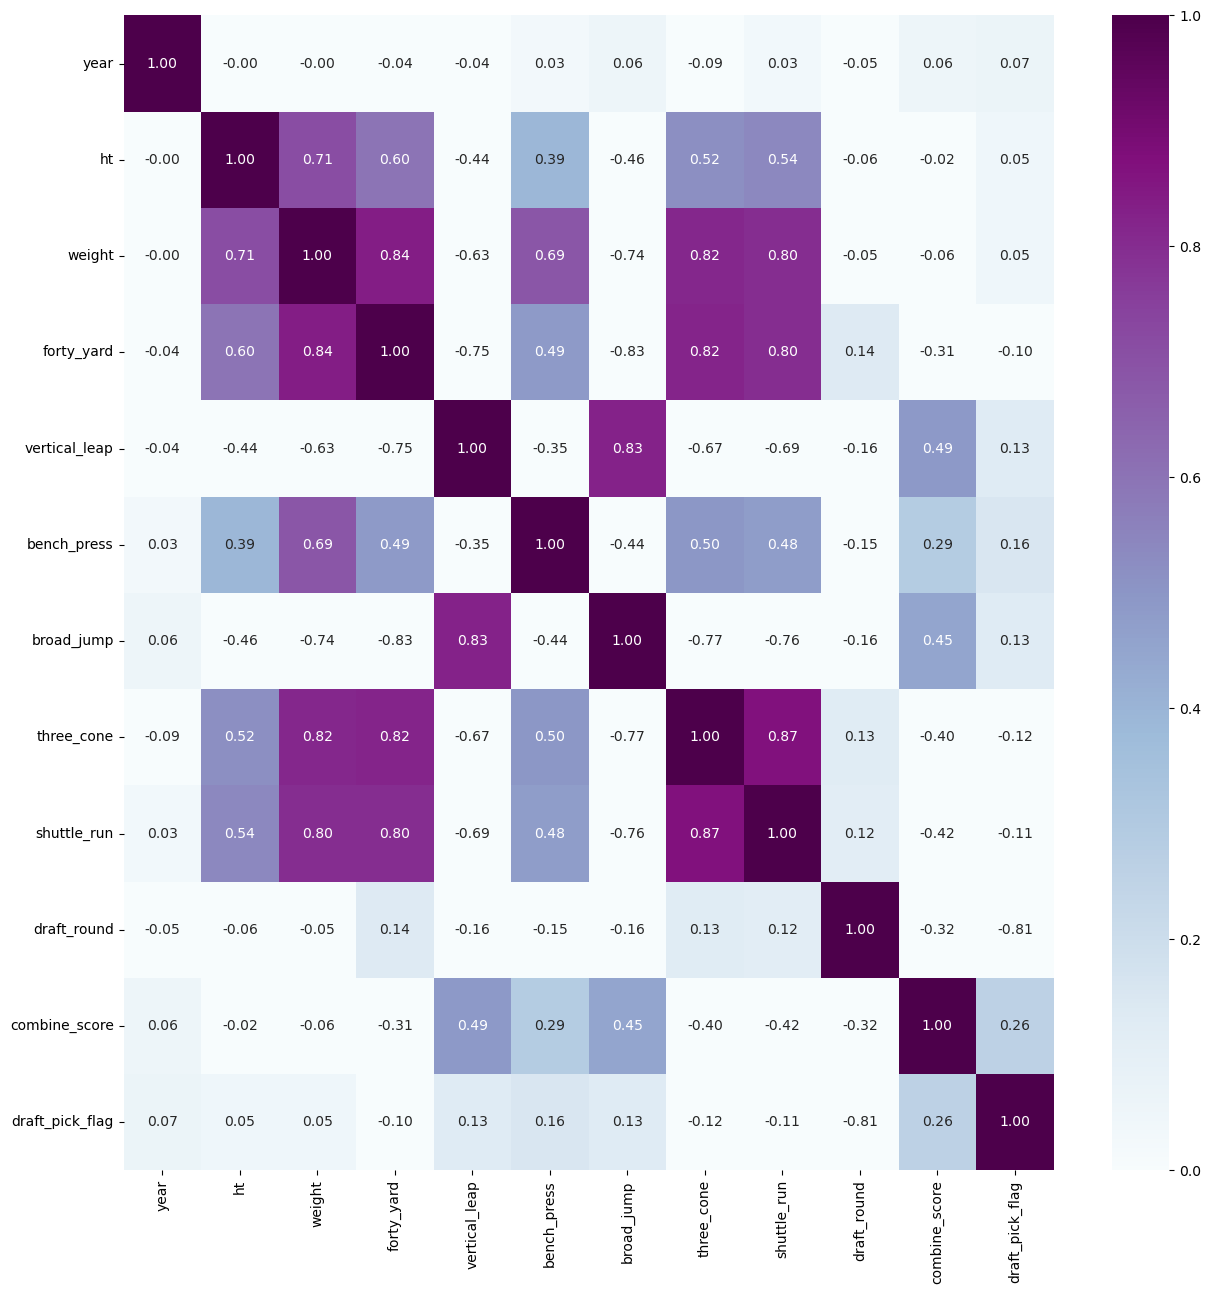

In [11]:
# Correlation Matrix
plt.figure(figsize=(15, 15))

corr_data = raw.copy()
corr_data
sns.heatmap(corr_data.corr(), cmap = 'BuPu', annot=True, fmt = '.2f', vmin=0)

# drop weight, drop shuttle run

In [12]:
# drop weight, drop shuttle run
# final features
drop_cols = ['player_id', 'year', 'School', 'player_name', 'height', 'three_cone', 'shuttle_run']


In [13]:
# preprocessing 
temp = raw.drop(drop_cols, axis=1)
obj_df = temp.select_dtypes(include = ['object']).copy()
obj_df['position_combine'] = obj_df['position_combine'].astype('category').cat.codes
obj_df['nfl_team'] = obj_df['nfl_team'].astype('category').cat.codes
obj_df['position_nfl_std'] = obj_df['position_nfl_std'].astype('category').cat.codes
obj_df.head()

,position_combine,nfl_team,position_nfl_std
0,9,21,2
1,13,26,11
2,10,15,5
3,15,31,14
4,1,4,1


In [14]:
temp.dtypes

position_combine     object
ht                    int64
weight              float64
forty_yard          float64
vertical_leap       float64
bench_press         float64
broad_jump          float64
draft_round         float64
nfl_team             object
position_nfl_std     object
combine_score       float64
draft_pick_flag       int64
dtype: object

In [15]:
features_df = temp.select_dtypes(include = ['int', 'float']).copy()
obj_df
features_df

df = pd.concat([features_df, obj_df], axis=1)
df.head()


median_imp = df.copy()
df_na = df.copy()

Using *Mice Imputation* To Fill in Data

In [16]:
mk = ImputationKernel(
    data = df,
    save_all_iterations=True
)

In [17]:
mk.mice(2)
mice_imputation = mk.complete_data()
mice_imputation.head()

,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,combine_score,draft_pick_flag,position_combine,nfl_team,position_nfl_std
0,76,252.0,4.55,34.5,23.0,118.0,1.0,17.0,1,9,21,2
1,72,218.0,4.58,35.0,20.0,119.0,1.0,16.0,1,13,26,11
2,76,334.0,5.56,25.0,23.0,94.0,6.0,7.0,1,10,15,5
3,74,253.0,4.97,29.0,19.5,104.0,8.0,9.0,0,15,31,14
4,74,206.0,4.55,34.0,15.0,123.0,1.0,17.0,1,1,4,1


In [18]:
df = mice_imputation.copy()

In [19]:
X = df.drop('draft_round', axis=1)
y = df['draft_round']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
# Decision Tree
md = df['draft_round'].nunique()
tree = DecisionTreeClassifier(max_depth=md)

tree.fit(X_train, y_train)

pred_tree = tree.predict(X_test)

acc_tree = accuracy_score(pred_tree, y_test)

print(acc_tree)

0.5511961722488038


In [21]:
# Naive Bayes
clf_nb = GaussianNB()

#fit model
clf_nb.fit(X_train, y_train)

#predictions
pred_nb = clf_nb.predict(X_test)

#acc score
acc_nb = accuracy_score(pred_nb, y_test)


print(acc_nb)

0.5569377990430622


In [22]:
# KNN
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(pred_knn, y_test)

print(acc_knn)


0.5358851674641149


In [23]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(pred_rf, y_test)

print(acc_rf)

0.55311004784689


Using *Median Imputation* to fill Nans

In [24]:
median_imp.head()

,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,combine_score,draft_pick_flag,position_combine,nfl_team,position_nfl_std
0,76,252.0,4.55,34.5,23.0,118.0,1.0,NaN,1,9,21,2
1,72,218.0,4.58,35.0,20.0,119.0,1.0,NaN,1,13,26,11
2,76,334.0,5.56,25.0,23.0,94.0,6.0,7.0,1,10,15,5
3,74,253.0,4.97,29.0,19.5,104.0,8.0,NaN,0,15,31,14
4,74,206.0,4.55,34.0,15.0,123.0,1.0,NaN,1,1,4,1


In [25]:
median_val = median_imp.median()
med_df = median_imp.fillna(median_val)
med_df.head()

,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,combine_score,draft_pick_flag,position_combine,nfl_team,position_nfl_std
0,76,252.0,4.55,34.5,23.0,118.0,1.0,16.0,1,9,21,2
1,72,218.0,4.58,35.0,20.0,119.0,1.0,16.0,1,13,26,11
2,76,334.0,5.56,25.0,23.0,94.0,6.0,7.0,1,10,15,5
3,74,253.0,4.97,29.0,19.5,104.0,8.0,16.0,0,15,31,14
4,74,206.0,4.55,34.0,15.0,123.0,1.0,16.0,1,1,4,1


In [26]:
X = med_df.drop('draft_round', axis=1)
y = med_df['draft_round']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
#Decision tree median
med_md = df['draft_round'].nunique()
med_tree = DecisionTreeClassifier(max_depth=md)
med_tree.fit(X_train, y_train)
med_pred_tree = med_tree.predict(X_test)
med_acc_tree = accuracy_score(med_pred_tree, y_test)
print(med_acc_tree)

0.5349282296650718


In [28]:
# Naive Bayes Median
med_nb = GaussianNB()
med_nb.fit(X_train, y_train)
med_pred_nb = med_nb.predict(X_test)
med_acc_nb = accuracy_score(med_pred_nb, y_test)
print(med_acc_nb)

0.5282296650717704


In [29]:
# KNN Median
knn.fit(X_train, y_train)
med_pred_knn = knn.predict(X_test)
med_acc_knn = accuracy_score(med_pred_knn, y_test)
print(med_acc_knn)

0.5205741626794258


In [30]:
# Random Forest

rf.fit(X_train, y_train)
med_pred_rf = rf.predict(X_test)
pred_acc_rf = accuracy_score(med_pred_rf, y_test)

print(pred_acc_rf)

0.5569377990430622


Seems like the models perform about the same using both methods to fill in data.

Let's see if scaling X will help our models

In [31]:
mice_imputation.head()

,ht,weight,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,combine_score,draft_pick_flag,position_combine,nfl_team,position_nfl_std
0,76,252.0,4.55,34.5,23.0,118.0,1.0,17.0,1,9,21,2
1,72,218.0,4.58,35.0,20.0,119.0,1.0,16.0,1,13,26,11
2,76,334.0,5.56,25.0,23.0,94.0,6.0,7.0,1,10,15,5
3,74,253.0,4.97,29.0,19.5,104.0,8.0,9.0,0,15,31,14
4,74,206.0,4.55,34.0,15.0,123.0,1.0,17.0,1,1,4,1


In [32]:
scale_df = mice_imputation.copy()

scaler = StandardScaler()

X = scale_df.drop('draft_round', axis=1)
y = df['draft_round']

scaler.fit(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [33]:
#Decision tree scaled

scale_tree = DecisionTreeClassifier(max_depth=md)
scale_tree.fit(X_train, y_train)
scale_pred_tree = scale_tree.predict(X_test)
scale_acc_tree = accuracy_score(scale_pred_tree, y_test)
print(scale_acc_tree)

0.5406698564593302


In [34]:
# Naive Bayes Scaled
scale_nb = GaussianNB()
scale_nb.fit(X_train, y_train)
scale_pred_nb = scale_nb.predict(X_test)
scale_acc_nb = accuracy_score(scale_pred_nb, y_test)
print(scale_acc_nb)

0.5377990430622009


In [35]:
# KNN Median Scale
knn.fit(X_train, y_train)
scale_pred_knn = knn.predict(X_test)
scale_acc_knn = accuracy_score(scale_pred_knn, y_test)
print(scale_acc_knn)

0.5244019138755981


In [36]:
# Random Forest Scale

rf.fit(X_train, y_train)
scale_pred_rf = rf.predict(X_test)
scale_acc_rf = accuracy_score(scale_pred_rf, y_test)

print(scale_acc_rf)

0.5339712918660288


Still about the same ...
Let's drop all Nans. This will normalize the data, but exclude a large chunck of our data and pretty much unusable since it's not realistic

In [37]:
con = sqlite3.connect('database.db')
df_na = pd.read_sql_query('SELECT*FROM players_raw', con)

In [38]:
df_na.dropna(inplace=True)
df_na

,player_id,player_name,year,School,position_combine,height,ht,weight,forty_yard,vertical_leap,...,position_nfl,position_nfl_std,bench_press_score,broad_jump_score,forty_yard_score,shuttle_run_score,three_cone_score,vertical_leap_score,combine_score,draft_pick_flag
2,2000ALFORDDARNELLBOS,Darnell Alford,2000,Boston Col.,OT,6 ft 4 in,76,334.0,5.56,25.0,...,G,G,2.0,1.0,1.0,1.0,1.0,1.0,7.0,1
9,2000AUSTINREGGIEWAK,Reggie Austin,2000,Wake Forest,CB,5 ft 9 in,69,175.0,4.44,35.0,...,DB,DB,4.0,2.0,3.0,3.0,2.0,2.0,16.0,1
11,2000BANIEWICZMARKSYR,Mark Baniewicz,2000,Syracuse,OT,6 ft 6 in,78,312.0,5.34,28.0,...,T,T,1.0,1.0,2.0,3.0,3.0,3.0,13.0,1
12,2000BARNESRASHIDICOL,Rashidi Barnes,2000,Colorado,S,6 ft 0 in,72,208.0,4.62,35.0,...,DB,DB,1.0,1.0,2.0,1.0,3.0,2.0,10.0,1
13,2000BARRETTDAVIDARK,David Barrett,2000,Arkansas,CB,5 ft 10 in,70,199.0,4.44,37.5,...,DB,DB,3.0,1.0,3.0,4.0,4.0,3.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5211,2015WILLIAMSMAXXMIN,Maxx Williams,2015,Minnesota,TE,6 ft 4 in,76,249.0,4.78,34.5,...,TE,TE,2.0,3.0,2.0,3.0,2.0,3.0,15.0,1
5212,2015WILLIAMSP.J.FLO,P.J. Williams,2015,Florida State,CB,6 ft 0 in,72,194.0,4.57,40.0,...,CB,DB,2.0,4.0,1.0,1.0,2.0,4.0,14.0,1
5214,2015WILSONDAMIENMIN,Damien Wilson,2015,Minnesota,ILB,6 ft 0 in,72,245.0,4.77,37.0,...,ILB,LB,3.0,4.0,2.0,4.0,2.0,4.0,19.0,1
5219,2015WRIGHTGABEAUB,Gabe Wright,2015,Auburn,DT,6 ft 3 in,75,300.0,5.07,26.5,...,DT,DT,4.0,1.0,3.0,3.0,2.0,1.0,14.0,1


In [39]:
df_na.groupby(by = 'position_combine')['player_id'].count()


position_combine
C       52
CB     163
DE     145
DT     129
FB      33
ILB     64
LS       1
OG     114
OLB    147
OT     155
QB       2
RB     113
S      113
TE      93
WR     107
Name: player_id, dtype: int64

In [42]:
#drop QB and LS since there is little data
df_na = df_na[(df_na['position_combine']!= 'LS') & (df_na['position_combine'] != 'QB')]
df_na.head()

,player_id,player_name,year,School,position_combine,height,ht,weight,forty_yard,vertical_leap,...,position_nfl,position_nfl_std,bench_press_score,broad_jump_score,forty_yard_score,shuttle_run_score,three_cone_score,vertical_leap_score,combine_score,draft_pick_flag
2,2000ALFORDDARNELLBOS,Darnell Alford,2000,Boston Col.,OT,6 ft 4 in,76,334.0,5.56,25.0,...,G,G,2.0,1.0,1.0,1.0,1.0,1.0,7.0,1
9,2000AUSTINREGGIEWAK,Reggie Austin,2000,Wake Forest,CB,5 ft 9 in,69,175.0,4.44,35.0,...,DB,DB,4.0,2.0,3.0,3.0,2.0,2.0,16.0,1
11,2000BANIEWICZMARKSYR,Mark Baniewicz,2000,Syracuse,OT,6 ft 6 in,78,312.0,5.34,28.0,...,T,T,1.0,1.0,2.0,3.0,3.0,3.0,13.0,1
12,2000BARNESRASHIDICOL,Rashidi Barnes,2000,Colorado,S,6 ft 0 in,72,208.0,4.62,35.0,...,DB,DB,1.0,1.0,2.0,1.0,3.0,2.0,10.0,1
13,2000BARRETTDAVIDARK,David Barrett,2000,Arkansas,CB,5 ft 10 in,70,199.0,4.44,37.5,...,DB,DB,3.0,1.0,3.0,4.0,4.0,3.0,18.0,1


In [44]:
#preprocessing
drop_cols = ['player_id', 'year', 'School', 'player_name', 'height', 'shuttle_run', 'three_cone', 'weight',
             'draft_pick_flag', 'vertical_leap_score', 'three_cone_score', 'shuttle_run_score', 'forty_yard_score',
             'broad_jump_score', 'bench_press_score', 'position_nfl']
temp = df_na.drop(drop_cols, axis=1)
obj_df = temp.select_dtypes(include = ['object']).copy()
obj_df['position_combine'] = obj_df['position_combine'].astype('category').cat.codes
obj_df['nfl_team'] = obj_df['nfl_team'].astype('category').cat.codes
obj_df['position_nfl_std'] = obj_df['position_nfl_std'].astype('category').cat.codes
obj_df.head()

,position_combine,nfl_team,position_nfl_std
2,8,15,5
9,1,5,1
11,8,14,8
12,10,7,1
13,1,0,1


In [45]:
features_df = temp.select_dtypes(include = ['int', 'float']).copy()
obj_df
features_df

df_na = pd.concat([features_df, obj_df], axis=1)

In [46]:
# drop all nans and drop all 'draft_round = 8'
df_na.dropna(inplace=True)
df_na = df_na[df_na['draft_round']!=8]
df_na

,ht,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,draft_pick,combine_score,position_combine,nfl_team,position_nfl_std
2,76,5.56,25.0,23.0,94.0,6.0,188.0,7.0,8,15,5
9,69,4.44,35.0,17.0,119.0,4.0,125.0,16.0,1,5,1
11,78,5.34,28.0,20.0,96.0,7.0,247.0,13.0,8,14,8
12,72,4.62,35.0,10.0,114.0,7.0,225.0,10.0,10,7,1
13,70,4.44,37.5,16.0,116.0,4.0,102.0,18.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5211,76,4.78,34.5,17.0,117.0,2.0,55.0,15.0,11,2,9
5212,72,4.57,40.0,12.0,132.0,3.0,78.0,14.0,1,18,1
5214,72,4.77,37.0,22.0,119.0,4.0,127.0,19.0,5,8,6
5219,75,5.07,26.5,34.0,100.0,4.0,113.0,14.0,3,10,3


In [47]:
df_na.describe()

,ht,forty_yard,vertical_leap,bench_press,broad_jump,draft_round,draft_pick,combine_score,position_combine,nfl_team,position_nfl_std
count,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000,1428.000000
mean,74.085434,4.794860,33.015756,21.939776,113.579132,4.003501,119.237395,16.415266,6.091737,15.505602,4.822829
std,2.700097,0.318347,4.219777,6.539129,9.319376,1.928465,69.441261,4.027302,3.685326,9.353711,3.108432
min,65.000000,4.260000,21.000000,2.000000,85.000000,1.000000,1.000000,6.000000,0.000000,0.000000,0.000000
25%,72.000000,4.530000,30.000000,17.000000,107.000000,2.000000,61.000000,13.000000,2.000000,7.000000,2.000000
50%,74.000000,4.710000,33.500000,22.000000,115.000000,4.000000,114.000000,17.000000,7.000000,16.000000,5.000000
75%,76.000000,5.060000,36.000000,26.000000,121.000000,6.000000,175.000000,20.000000,9.000000,24.000000,7.000000
max,80.000000,5.650000,45.000000,45.000000,139.000000,7.000000,259.000000,24.000000,12.000000,31.000000,10.000000


<Axes: >

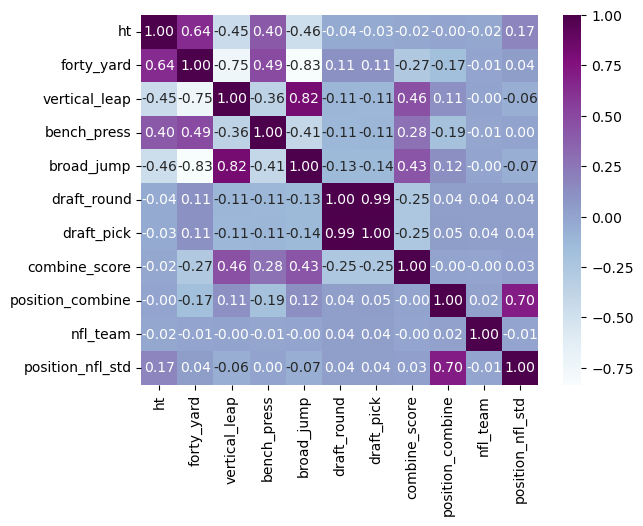

In [48]:
sns.heatmap(df_na.corr(), cmap = 'BuPu', annot=True, fmt = '.2f', vmax=True)

In [49]:
len(df_na)

1428

In [50]:
scaler = StandardScaler()

X = df_na.drop('draft_round', axis=1)
y = df_na['draft_round']

scaler.fit(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [51]:
#Decision tree drop nans
md = y.nunique()
na_tree = DecisionTreeClassifier(max_depth=md)
na_tree.fit(X_train, y_train)
na_pred_tree = na_tree.predict(X_test)
na_acc_tree = accuracy_score(na_pred_tree, y_test)
print(na_acc_tree)

0.958041958041958


In [52]:
# Naive Bayes drop nans
na_nb = GaussianNB()
na_nb.fit(X_train, y_train)
na_pred_nb = na_nb.predict(X_test)
na_acc_nb = accuracy_score(na_pred_nb, y_test)
print(na_acc_nb)

0.9440559440559441


In [53]:
# KNN Drop Nans
knn.fit(X_train, y_train)
na_pred_knn = knn.predict(X_test)
na_acc_knn = accuracy_score(na_pred_knn, y_test)
print(na_acc_knn)

0.9300699300699301


In [54]:
# Random Forest drop Nans

rf.fit(X_train, y_train)
na_pred_rf = rf.predict(X_test)
na_acc_rf = accuracy_score(na_pred_rf, y_test)

print(na_acc_rf)

pred_df = pd.DataFrame({
    'predicted': na_pred_rf,
    'actual': y_test
})



0.9440559440559441
